In [ ]:
# Stain_normalize patches in BCNB dataset

import os
from PIL import Image
import numpy as np
import h5py
import random
import matplotlib.pyplot as plt

datafolder = "/home/hu-eki/Data/BCNB/paper_patches"

patches_folder = os.path.join(datafolder, "patches")
target_folder = os.path.join(datafolder, "patches_normalized")
h5_folder = "/home/hu-eki/Projects/HEST/tutorials/hest_data/patches"
h5_cases = ['TENX99', 'TENX96', 'TENX95', 'NCBI783', 'NCBI785']

def plot_reference_patch(reference_patch):
    # Plot the reference patch
    plt.figure(figsize=(5, 5))
    plt.imshow(reference_patch)
    plt.title("Reference Patch")
    plt.axis('off')
    plt.show()
    
    # Plot the color spectrum (histograms for R, G, B channels)
    plt.figure(figsize=(10, 3))
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        hist, bins = np.histogram(reference_patch[:, :, i].flatten(), bins=256, range=[0, 256])
        plt.plot(bins[:-1], hist, color=color, label=f'{color.upper()} channel')
    plt.title('Color Spectrum')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


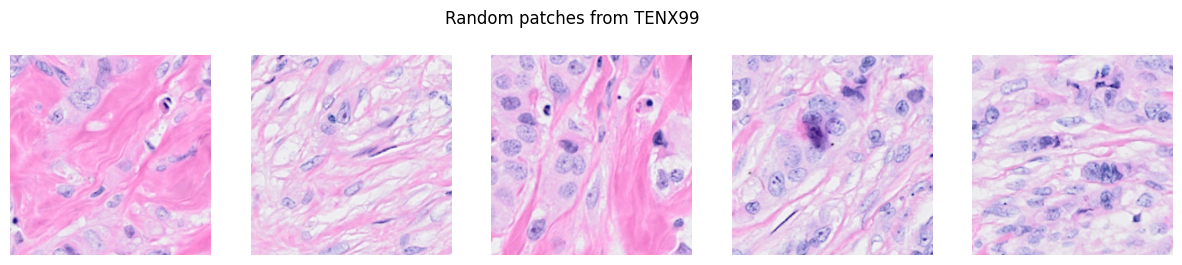

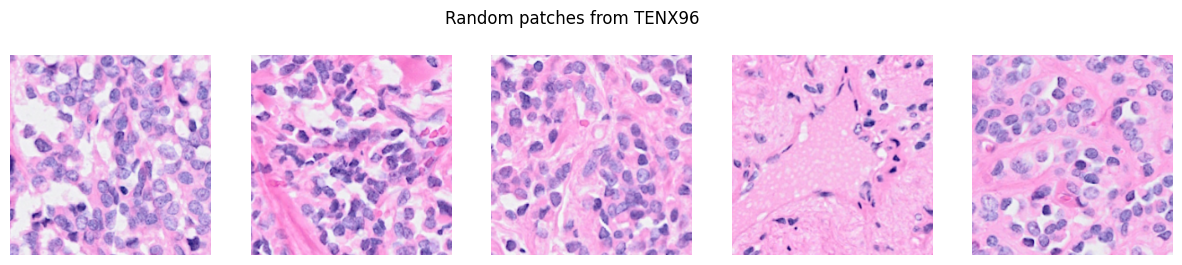

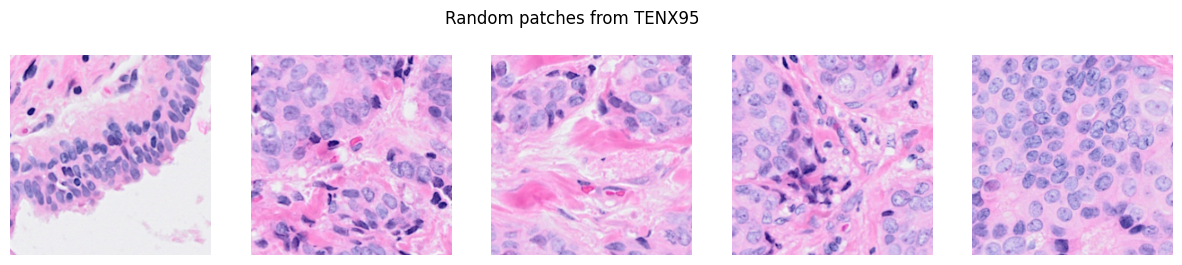

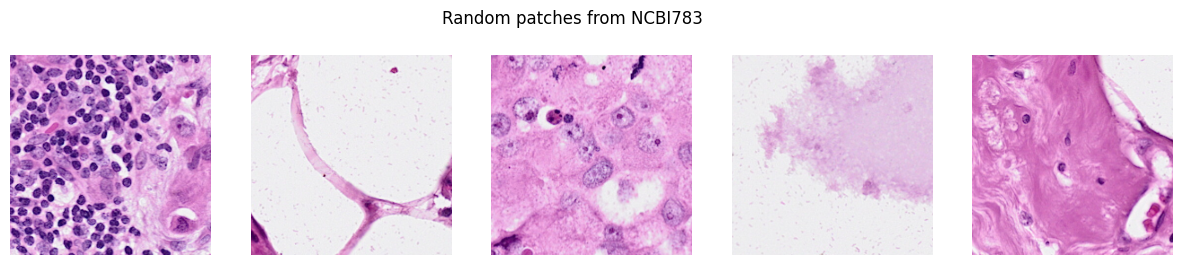

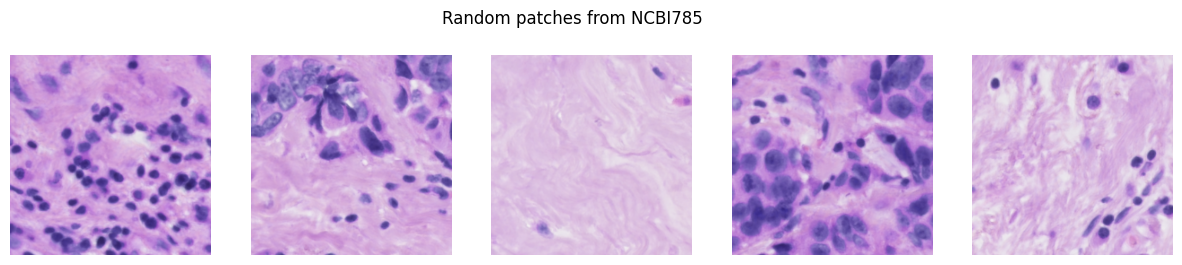

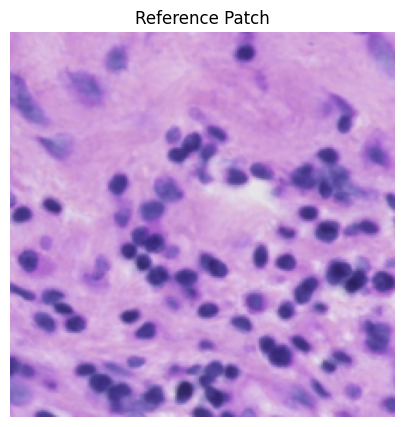

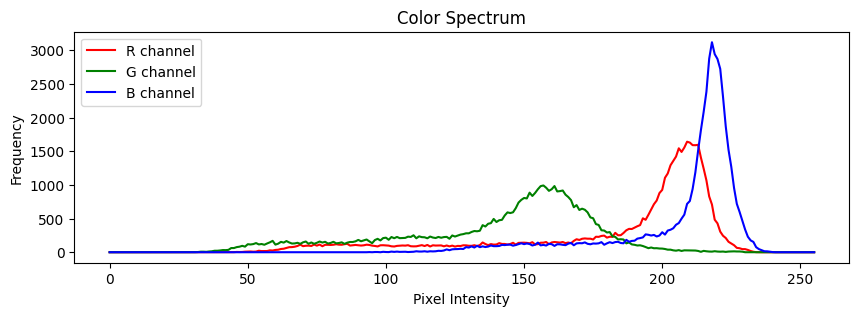

In [155]:
reference_case = 4
reference_patch = None

for current_case in h5_cases:
    h5_path = os.path.join(h5_folder, f"{current_case}.h5")
    with h5py.File(h5_path, 'r') as h5_file:
        # Assume the patches are stored in a dataset named 'img'
        patches = h5_file['img']
        if len(patches) < 5:
            sample_indices = list(range(len(patches)))
        else:
            sample_indices = random.sample(range(len(patches)), 5)
        plt.figure(figsize=(15, 3))
        for idx, patch_idx in enumerate(sample_indices):
            plt.subplot(1, 5, idx+1)
            plt.imshow(patches[patch_idx])
            plt.axis('off')
        plt.suptitle(f"Random patches from {current_case}")
        plt.show()
        
        # Pick one of the patches as reference if the case matches the global variable 'case'
        if current_case == h5_cases[reference_case] and reference_patch is None:
            reference_patch = patches[sample_indices[0]]

plot_reference_patch(reference_patch)

In [128]:
references += [reference_patch]
print(len(references))

10


In [162]:
reference_patch.shape
Image.fromarray(reference_patch).save("reference_patch.jpg")

In [163]:
from tqdm import tqdm
#from torchvahadane import TorchVahadaneNormalizer
from torch_staintools.normalizer import NormalizerBuilder
import torch
import cv2
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import convert_image_dtype

device = torch.device("cuda:0")
def postprocess(image_tensor): return convert_image_dtype(image_tensor, torch.uint8)\
    .squeeze().detach().cpu().permute(1, 2, 0).numpy()

# Initialize the normalizer with the reference tile
# normalizer = NormalizerBuilder.build('vahadane', concentration_method='cd', use_cache=True,
#                                               rng=1, device=device
#                                               )
normalizer = NormalizerBuilder.build('macenko', use_cache=False,
                                             # use least square solver, along with cache, to perform
                                             # normalization on-the-fly
                                             concentration_method='ista')

reference_patch_tensor = ToTensor()(reference_patch).unsqueeze(0).to(device)
normalizer.fit(reference_patch_tensor)
    


In [164]:
# Loop over all subfolders in BCNB and process .jpg images
for root, dirs, files in tqdm(list(os.walk(patches_folder)), desc="Processing folders", unit="folder"):
    for file in tqdm(files, desc="Processing images", unit="file", leave=False):
        if file.lower().endswith('.jpg'):
            patch_path = os.path.join(root, file)
            image = np.array(Image.open(patch_path).convert("RGB"))
            image_tensor = ToTensor()(image).unsqueeze(0).to(device)
            #norm_image = normalizer.transform(image.copy())
            norm_image = postprocess(normalizer(image_tensor))

            # Maintain folder structure in target_folder
            rel_dir = os.path.relpath(root, patches_folder)
            save_dir = os.path.join(target_folder, rel_dir)
            os.makedirs(save_dir, exist_ok=True)
            
            save_path = os.path.join(save_dir, file)
            Image.fromarray(norm_image.astype(np.uint8)).save(save_path)


Processing folders: 100%|██████████| 1060/1060 [35:20<00:00,  2.00s/folder] 


Processing patches in NCBI785: 100%|██████████| 4074/4074 [01:34<00:00, 42.93patch/s]


Barcodes exist in the h5 file.
Barcodes still exist in the h5 file!


Processing patches in NCBI783: 100%|██████████| 3501/3501 [01:15<00:00, 46.23patch/s]


Barcodes exist in the h5 file.
Barcodes still exist in the h5 file!


Processing patches in TENX95: 100%|██████████| 7592/7592 [02:09<00:00, 58.82patch/s]


Barcodes exist in the h5 file.
Barcodes still exist in the h5 file!


Processing patches in TENX96:  98%|█████████▊| 6034/6177 [01:57<00:02, 57.56patch/s]

Error processing patch 6035 in TENX96: Empty tissue mask computed


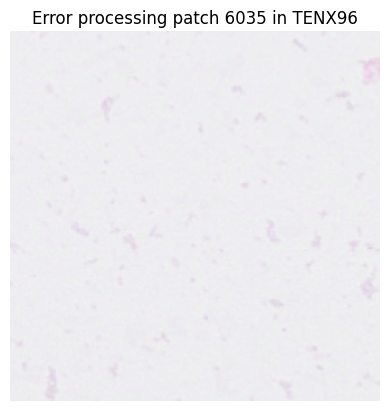

Processing patches in TENX96: 100%|██████████| 6177/6177 [02:00<00:00, 51.31patch/s]


Barcodes exist in the h5 file.
Barcodes still exist in the h5 file!


Processing patches in TENX99:  50%|█████     | 10312/20549 [02:51<02:41, 63.51patch/s]

Error processing patch 10313 in TENX99: Empty tissue mask computed


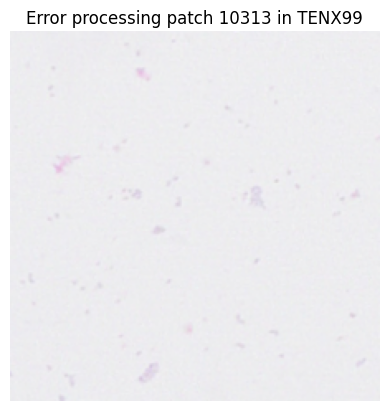

Processing patches in TENX99: 100%|██████████| 20549/20549 [05:41<00:00, 60.23patch/s]


Barcodes exist in the h5 file.
Barcodes still exist in the h5 file!


In [178]:
import shutil


# Process HEST .h5 files and save normalized patches to the new target folder
h5_target_folder = "/home/hu-eki/Projects/HEST/tutorials/hest_data/patches_normalized"
os.makedirs(h5_target_folder, exist_ok=True)

for current_case in reversed(h5_cases):
    h5_path = os.path.join(h5_folder, f"{current_case}.h5")
    # After processing all patches, create a new h5 file copying all keys except 'img'
    new_h5_path = os.path.join(h5_target_folder, f"{current_case}.h5")
    shutil.copyfile(h5_path, new_h5_path)
    with h5py.File(h5_path, 'r') as h5_file:
        patches = h5_file['img']
        
        # Accumulate normalized patches in a preallocated array
        all_norms = np.empty((len(patches),) + patches[0].shape, dtype=patches.dtype)
        for i in tqdm(range(len(patches)), desc=f"Processing patches in {current_case}", unit="patch"):
            patch = patches[i]
            patch_tensor = ToTensor()(patch).unsqueeze(0).to(device)
            try:
                norm_patch = postprocess(normalizer.transform(patch_tensor))
                all_norms[i] = norm_patch.astype(np.uint8)
            except Exception as e:
                print(f"Error processing patch {i} in {current_case}: {e}")
                plt.imshow(patch)
                plt.title(f"Error processing patch {i} in {current_case}")
                plt.axis("off")
                plt.show()
                all_norms[i] = patch
                
        
        
        with h5py.File(new_h5_path, 'a') as h5_new:
            # if 'img' in h5_new:
            #     del h5_new['img']
            try:
                barcodes = h5_new['barcode'][:]
                print('Barcodes exist in the h5 file.')
            except KeyError:
                print(f"'barcode' dataset not found in {new_h5_path}.")
            h5_new['img'][:] = all_norms
            try:
                barcodes = h5_new['barcode'][:]
                print('Barcodes still exist in the h5 file!')
            except KeyError:
                print(f"'barcode' dataset not found in {new_h5_path}.")
       

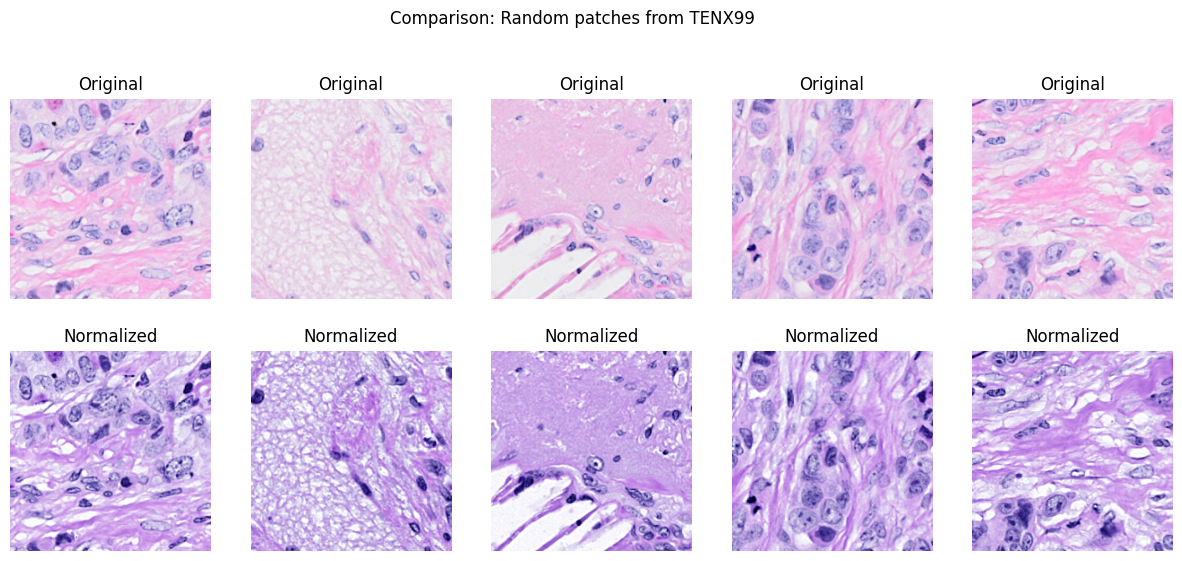

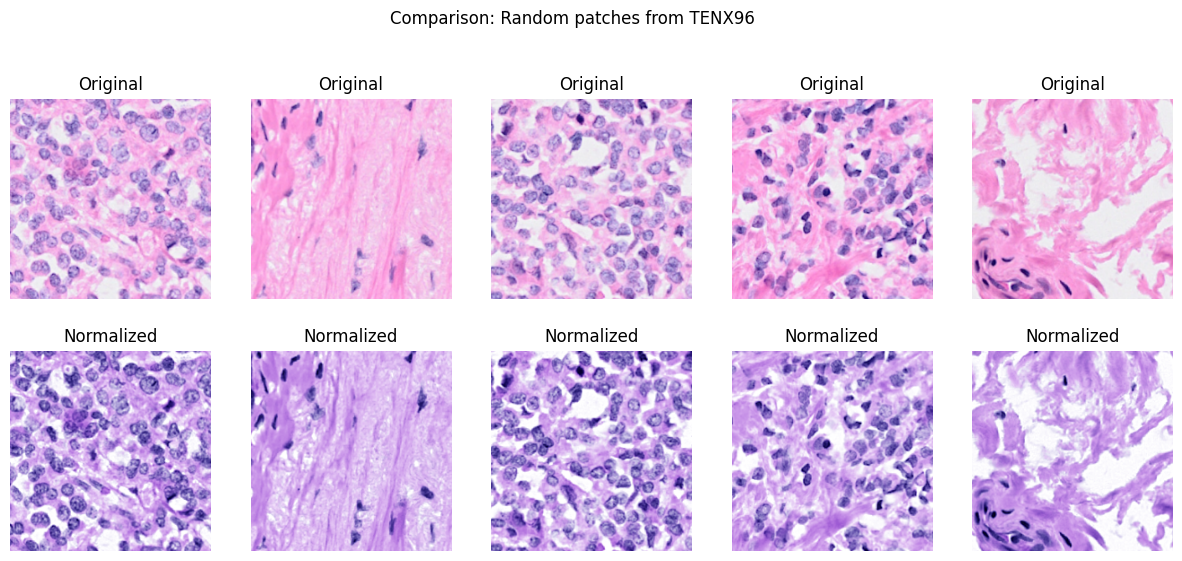

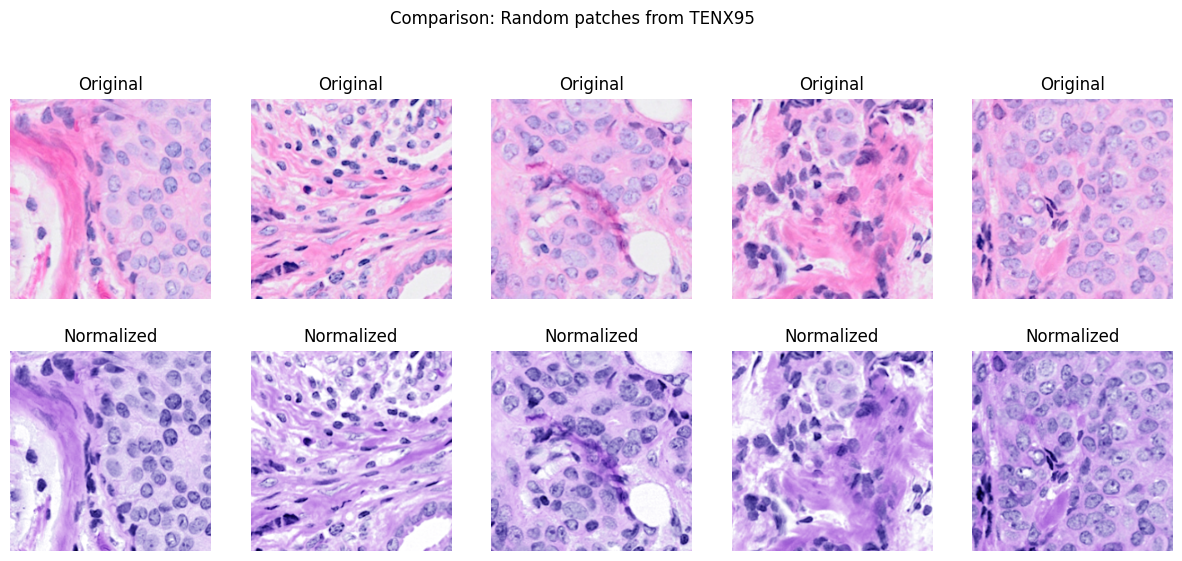

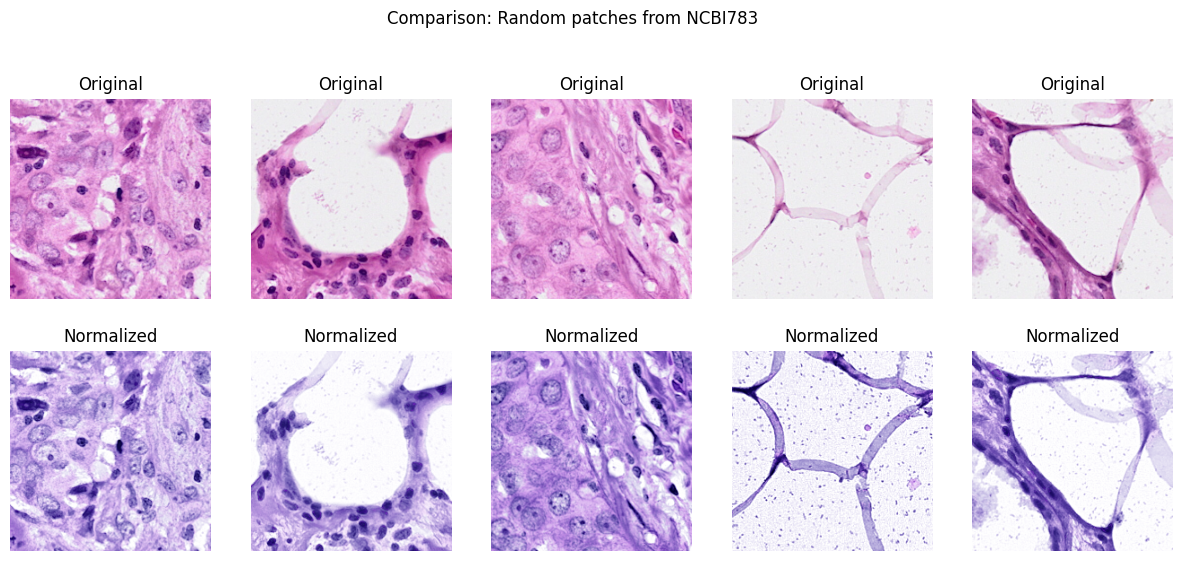

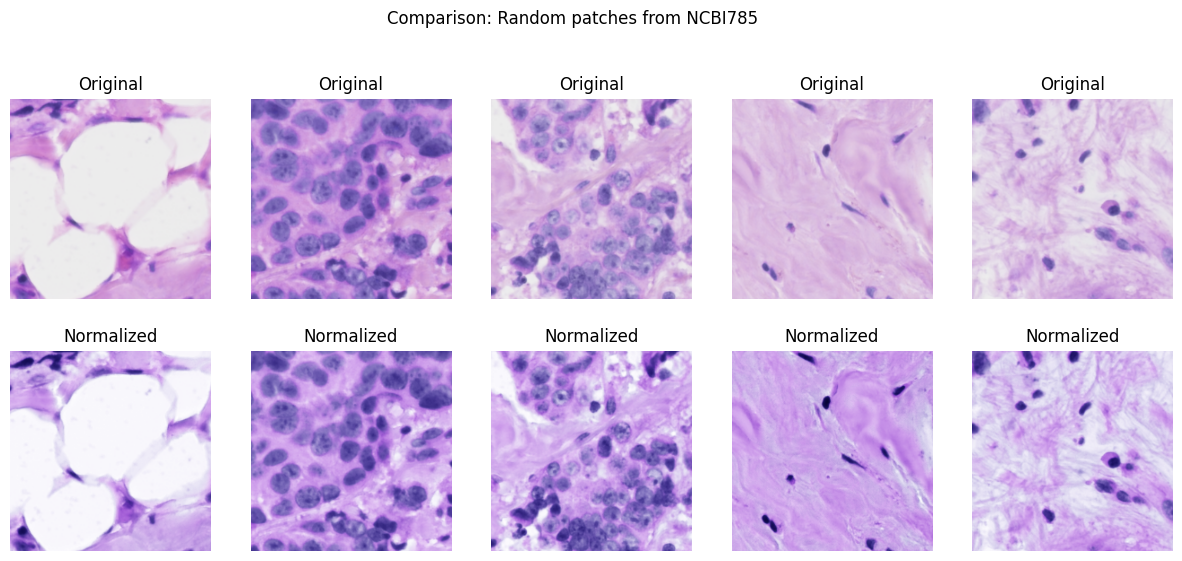

In [179]:
for current_case in h5_cases:
    h5_path = os.path.join(h5_folder, f"{current_case}.h5")
    new_h5_path = os.path.join(h5_target_folder, f"{current_case}.h5")
    with h5py.File(h5_path, 'r') as h5_file, h5py.File(new_h5_path, 'r') as h5_new:
        # Assume the patches are stored in a dataset named 'img'
        patches = h5_file['img']
        new_patches = h5_new['img']
        if len(patches) < 5:
            sample_indices = list(range(len(patches)))
        else:
            sample_indices = random.sample(range(len(patches)), 5)
        fig, axes = plt.subplots(2, len(sample_indices), figsize=(15, 6))
        for idx, patch_idx in enumerate(sample_indices):
            axes[0, idx].imshow(patches[patch_idx])
            axes[0, idx].axis('off')
            axes[0, idx].set_title("Original")
            
            axes[1, idx].imshow(new_patches[patch_idx])
            axes[1, idx].axis('off')
            axes[1, idx].set_title("Normalized")
            
        plt.suptitle(f"Comparison: Random patches from {current_case}", y=1.02)
        plt.show()

In [ ]:
h5_folder = "/home/hu-eki/Data/HEST/patches"
h5_target_folder = "/home/hu-eki/Data/HEST/patches_normalized"

for current_case in h5_cases:
    h5_path = os.path.join(h5_folder, f"{current_case}.h5")
    new_h5_path = os.path.join(h5_target_folder, f"{current_case}.h5")
    with h5py.File(h5_path, 'r') as h5_file, h5py.File(new_h5_path, 'r') as h5_new:
        # Assume the patches are stored in a dataset named 'img'
        patches = h5_file['img']
        new_patches = h5_new['img']
        if len(patches) < 5:
            sample_indices = list(range(len(patches)))
        else:
            sample_indices = random.sample(range(len(patches)), 5)
        fig, axes = plt.subplots(2, len(sample_indices), figsize=(15, 6))
        for idx, patch_idx in enumerate(sample_indices):
            axes[0, idx].imshow(patches[patch_idx])
            axes[0, idx].axis('off')
            axes[0, idx].set_title("Original")
            
            axes[1, idx].imshow(new_patches[patch_idx])
            axes[1, idx].axis('off')
            axes[1, idx].set_title("Normalized")
            
        plt.suptitle(f"Comparison: Random patches from {current_case}", y=1.02)
        plt.show()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'home/hu-eki/Data/HEST/patches_normalized/TENX99.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)